In [1]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [22]:
sc.applicationId

'application_1695816874646_4497'

In [ ]:
http://localhost:8088/proxy/<sc.applicationId>

In [ ]:
http://localhost:8088/proxy/application_1695816874646_4497

# Задача Wordcount

In [3]:
rdd = sc.textFile("/data/wiki")

In [4]:
rdd

/data/wiki MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
rdd.count()

2129797

In [7]:
# выводим первые 2 строчки из файла
rdd.take(2)

['<doc id="4" url="https://ru.wikipedia.org/wiki?curid=4" title="Базовая статья">',
 'Базовая статья']

In [9]:
# строим граф вычислений
rdd1 = rdd.map(lambda x: x.strip().lower()) # приводим к нижнему регистру. одна запись состоит из словаря из нескольких слов
rdd2 = rdd1.flatMap(lambda x: x.split()) # однеа запись = 1 слово
rdd3 = rdd2.map(lambda x: (x, 1)) # собираем пары (word, 1)
rdd4 = rdd3.reduceByKey(lambda a, b: a + b) # суммируем 1 с одинаковыми ключами
rdd5 = rdd4.sortBy(lambda a: -a[1]) # сортируем по количеству встречаемости

In [10]:
rdd1.take(5)

['<doc id="4" url="https://ru.wikipedia.org/wiki?curid=4" title="базовая статья">',
 'базовая статья',
 '',
 '',
 '']

In [11]:
rdd2.take(5)

['<doc',
 'id="4"',
 'url="https://ru.wikipedia.org/wiki?curid=4"',
 'title="базовая',
 'статья">']

In [12]:
rdd3.take(5)

[('<doc', 1),
 ('id="4"', 1),
 ('url="https://ru.wikipedia.org/wiki?curid=4"', 1),
 ('title="базовая', 1),
 ('статья">', 1)]

In [13]:
rdd4.take(5)

[('id="4"', 1),
 ('title="базовая', 3),
 ('</doc>', 107703),
 ('url="https://ru.wikipedia.org/wiki?curid=7"', 1),
 ('литва', 229)]

In [14]:
rdd5.take(5)

[('в', 2729399), ('и', 1851941), ('на', 851144), ('с', 657297), ('—', 630009)]

In [16]:
# посмотрим на план RDD
print(rdd5.toDebugString().decode('utf-8'))

(3) PythonRDD[25] at RDD at PythonRDD.scala:53 []
 |  MapPartitionsRDD[19] at mapPartitions at PythonRDD.scala:133 []
 |  ShuffledRDD[18] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(3) PairwiseRDD[17] at sortBy at <ipython-input-9-ed5580987be7>:6 []
    |  PythonRDD[16] at sortBy at <ipython-input-9-ed5580987be7>:6 []
    |  MapPartitionsRDD[13] at mapPartitions at PythonRDD.scala:133 []
    |  ShuffledRDD[12] at partitionBy at NativeMethodAccessorImpl.java:0 []
    +-(3) PairwiseRDD[11] at reduceByKey at <ipython-input-9-ed5580987be7>:5 []
       |  PythonRDD[10] at reduceByKey at <ipython-input-9-ed5580987be7>:5 []
       |  /data/wiki MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 []
       |  /data/wiki HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 []


# Очистим от знаков препинания

In [18]:
import re 

In [19]:
# строим граф вычислений
rdd1 = rdd.map(lambda x: x.strip().lower()) # приводим к нижнему регистру. одна запись состоит из словаря из нескольких слов
rdd1_5 = rdd1.map(lambda x: re.sub(u"\\W+", " ", x, flags=re.U)) # очищаем от знаков препинания
rdd2 = rdd1_5.flatMap(lambda x: x.split()) # однеа запись = 1 слово
rdd2_5 = rdd2.filter(lambda x: len(x) >= 3)
# rdd2_5 = rdd2.filter(lambda x: len(x) >= 3).cash   # кеширование, если мы хотим использовать этот результат дальше
rdd3 = rdd2_5.map(lambda x: (x, 1)) # собираем пары (word, 1)
rdd4 = rdd3.reduceByKey(lambda a, b: a + b) # суммируем 1 с одинаковыми ключами
rdd5 = rdd4.sortBy(lambda a: -a[1]) # сортируем по количеству встречаемости

In [20]:
rdd5.take(10)

[('года', 344878),
 ('году', 296827),
 ('что', 293546),
 ('для', 250587),
 ('как', 241345),
 ('его', 235466),
 ('был', 221287),
 ('doc', 215451),
 ('также', 161831),
 ('при', 148927)]

# Broadcast - переменные

Делается, когда мы хотим сделать маленький джоин типа списка стоп слов

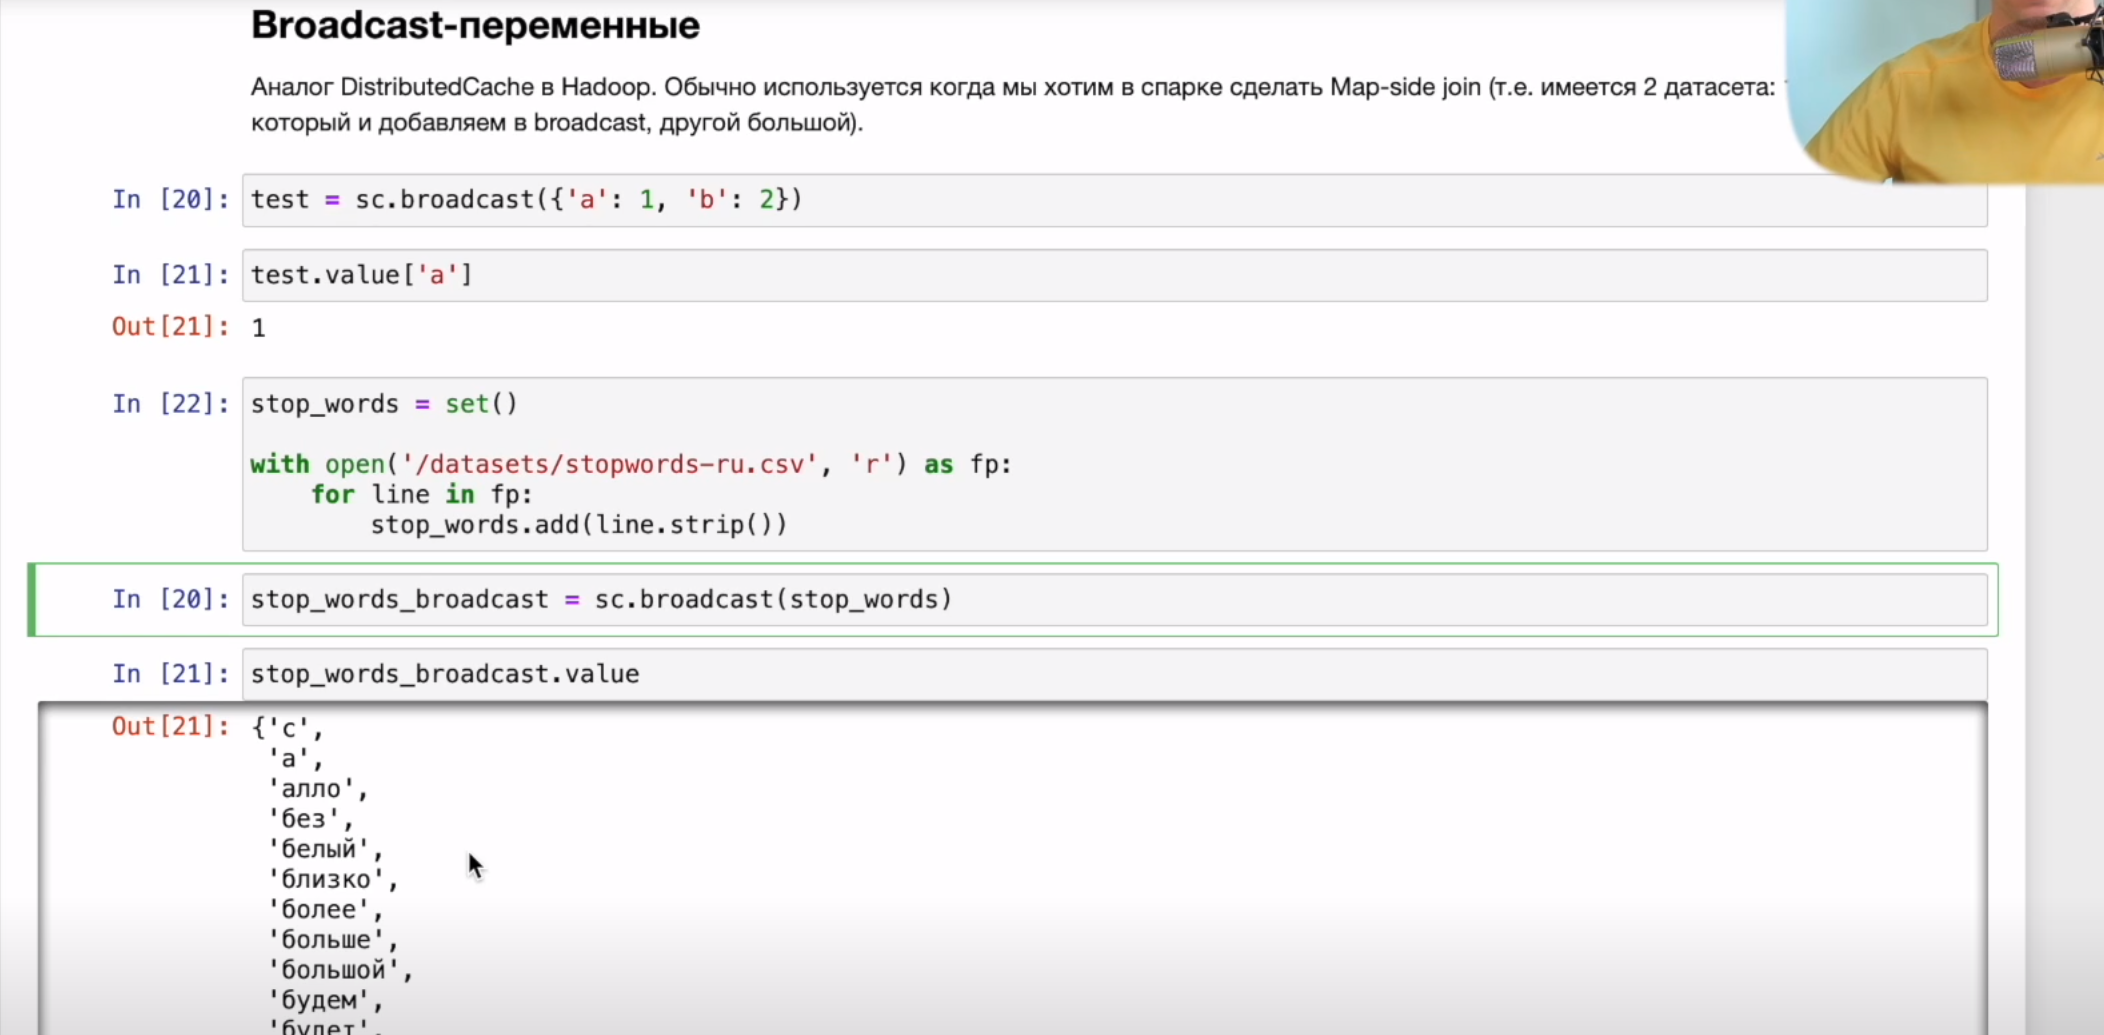

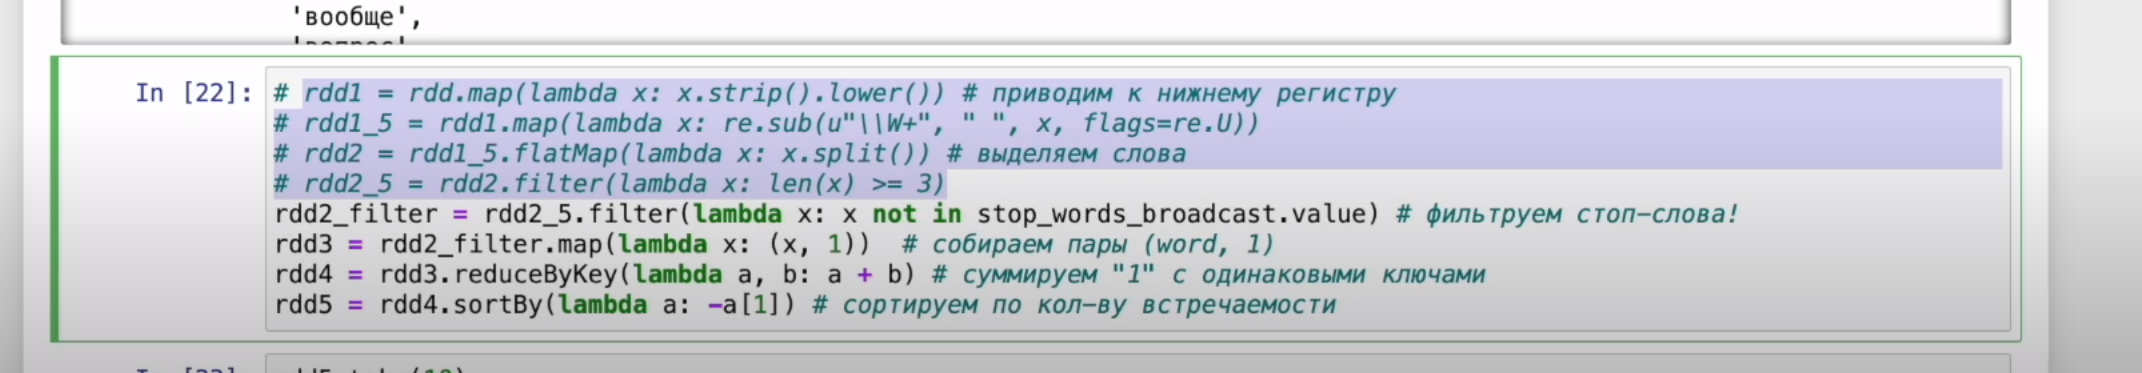

# Join таблиц

In [1]:
business = sc.textFile('/data/yelp/business')

In [2]:
review = sc.textFile('/data/yelp/review')

In [3]:
business.take(5)

['{"business_id":"Pns2l4eNsfO8kk83dixA6A","name":"Abby Rappoport, LAC, CMQ","address":"1616 Chapala St, Ste 2","city":"Santa Barbara","state":"CA","postal_code":"93101","latitude":34.4266787,"longitude":-119.7111968,"stars":5.0,"review_count":7,"is_open":0,"attributes":{"ByAppointmentOnly":"True"},"categories":"Doctors, Traditional Chinese Medicine, Naturopathic\\/Holistic, Acupuncture, Health & Medical, Nutritionists","hours":null}',
 '{"business_id":"mpf3x-BjTdTEA3yCZrAYPw","name":"The UPS Store","address":"87 Grasso Plaza Shopping Center","city":"Affton","state":"MO","postal_code":"63123","latitude":38.551126,"longitude":-90.335695,"stars":3.0,"review_count":15,"is_open":1,"attributes":{"BusinessAcceptsCreditCards":"True"},"categories":"Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services","hours":{"Monday":"0:0-0:0","Tuesday":"8:0-18:30","Wednesday":"8:0-18:30","Thursday":"8:0-18:30","Friday":"8:0-18:30","Saturday":"8:0-14:0"}}',
 '{"business_id":"tUFrWirK

In [4]:
review.take(5)

['{"review_id":"KU_O5udG6zpxOg-VcAEodg","user_id":"mh_-eMZ6K5RLWhZyISBhwA","business_id":"XQfwVwDr-v0ZS3_CbbE5Xw","stars":3.0,"useful":0,"funny":0,"cool":0,"text":"If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it\'s other locations in NJ and never had a bad experience. \\n\\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.","date":"2018-07-07 22:09:11"}',
 '{"review_id":"BiTunyQ73aT9WBnpR9DZGw","user_id":"OyoGAe7OKpv6SyGZT5g77Q","business_id":"7ATYjTIgM3jUlt4UM3IypQ","stars":5.0,"useful":1,"funny":0,"cool":1,"text":"I\'ve taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clea

In [5]:
import json

In [6]:
review_rdd = review.map(lambda x: json.loads(x))
business_rdd = business.map(lambda x: json.loads(x))

In [7]:
review_rdd.take(1)

[{'review_id': 'KU_O5udG6zpxOg-VcAEodg',
  'user_id': 'mh_-eMZ6K5RLWhZyISBhwA',
  'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw',
  'stars': 3.0,
  'useful': 0,
  'funny': 0,
  'cool': 0,
  'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
  'date': '2018-07-07 22:09:11'}]

In [8]:
business_rdd.take(1)

[{'business_id': 'Pns2l4eNsfO8kk83dixA6A',
  'name': 'Abby Rappoport, LAC, CMQ',
  'address': '1616 Chapala St, Ste 2',
  'city': 'Santa Barbara',
  'state': 'CA',
  'postal_code': '93101',
  'latitude': 34.4266787,
  'longitude': -119.7111968,
  'stars': 5.0,
  'review_count': 7,
  'is_open': 0,
  'attributes': {'ByAppointmentOnly': 'True'},
  'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
  'hours': None}]

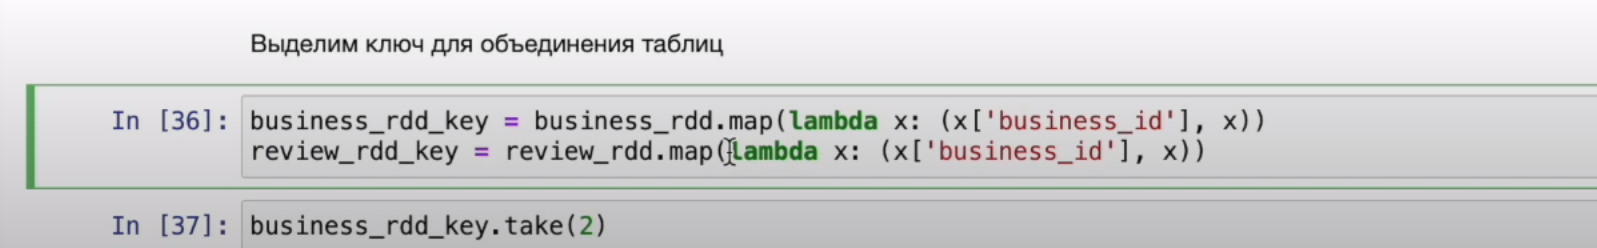

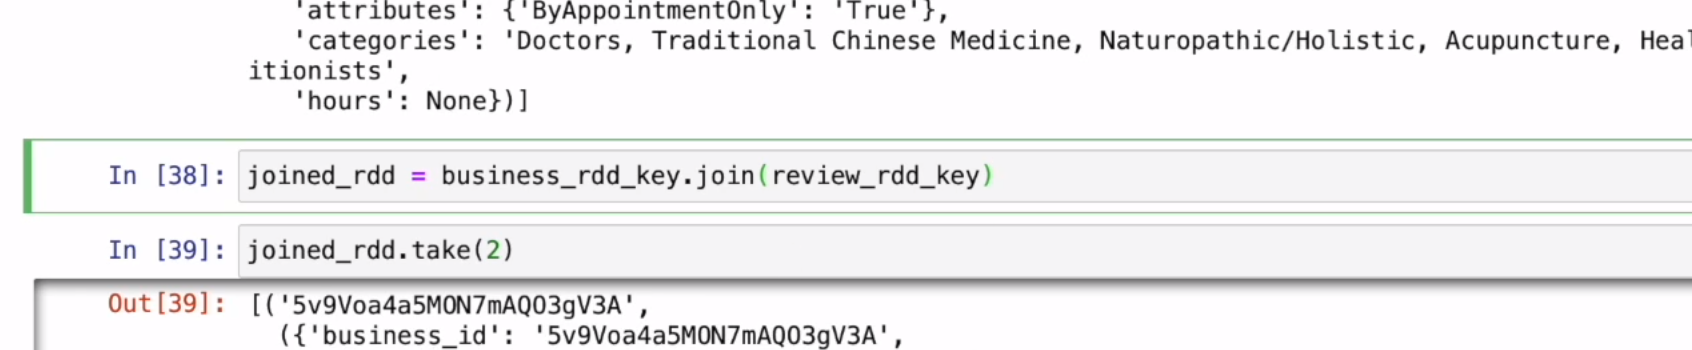

In [9]:
# выделим ключ для объединения таблиц
business_rdd_key = business_rdd.map(lambda x: (x['business_id'], x))
review_rdd_key = review_rdd.map(lambda x: (x['business_id'], x))

In [10]:
business_rdd_key.take(1)

[('Pns2l4eNsfO8kk83dixA6A',
  {'business_id': 'Pns2l4eNsfO8kk83dixA6A',
   'name': 'Abby Rappoport, LAC, CMQ',
   'address': '1616 Chapala St, Ste 2',
   'city': 'Santa Barbara',
   'state': 'CA',
   'postal_code': '93101',
   'latitude': 34.4266787,
   'longitude': -119.7111968,
   'stars': 5.0,
   'review_count': 7,
   'is_open': 0,
   'attributes': {'ByAppointmentOnly': 'True'},
   'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
   'hours': None})]

In [11]:
joined_rdd = business_rdd_key.join(review_rdd_key)

In [12]:
joined_rdd.take(1)

[('C43IEVBroD_3YiumPPLLdQ',
  ({'business_id': 'C43IEVBroD_3YiumPPLLdQ',
    'name': 'Half Price Books',
    'address': '4709 E 82nd St',
    'city': 'Indianapolis',
    'state': 'IN',
    'postal_code': '46250',
    'latitude': 39.9048037,
    'longitude': -86.0898087,
    'stars': 4.0,
    'review_count': 48,
    'is_open': 1,
    'attributes': {'RestaurantsPriceRange2': '1',
     'BikeParking': 'False',
     'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
     'BusinessAcceptsCreditCards': 'True',
     'DogsAllowed': 'False',
     'RestaurantsDelivery': 'False',
     'RestaurantsTakeOut': 'True'},
    'categories': 'Books, Mags, Music & Video, Comic Books, Shopping, Bookstores',
    'hours': {'Monday': '10:0-20:0',
     'Tuesday': '10:0-16:0',
     'Wednesday': '10:0-20:0',
     'Thursday': '10:0-20:0',
     'Friday': '10:0-20:0',
     'Saturday': '10:0-20:0',
     'Sunday': '11:0-18:0'}},
   {'review_id': '3iehwIe_moiun65d-9

Сделаем отдельную аггрегацию

In [13]:
def get_stats(business_review):
    return (business_review[0]), {
        'business_id': business_review[1][0]['business_id'],
        'city': business_review[1][0]['city'],
        'longitude': business_review[1][0]['longitude'],
        'latitude': business_review[1][0]['latitude'],
        'review_id': business_review[1][1]['review_id'],
        'stars': business_review[1][1]['stars']
    }

In [14]:
joined_rdd_projection = joined_rdd.map(get_stats)

In [15]:
joined_rdd_projection.take(1)

[('zFvqulgAYOpSG2t1v8AZ-w',
  {'business_id': 'zFvqulgAYOpSG2t1v8AZ-w',
   'city': 'Tampa',
   'longitude': -82.4764699,
   'latitude': 27.935753,
   'review_id': 'mf5RfdsfXtC4C77f-EU5Vw',
   'stars': 5.0})]

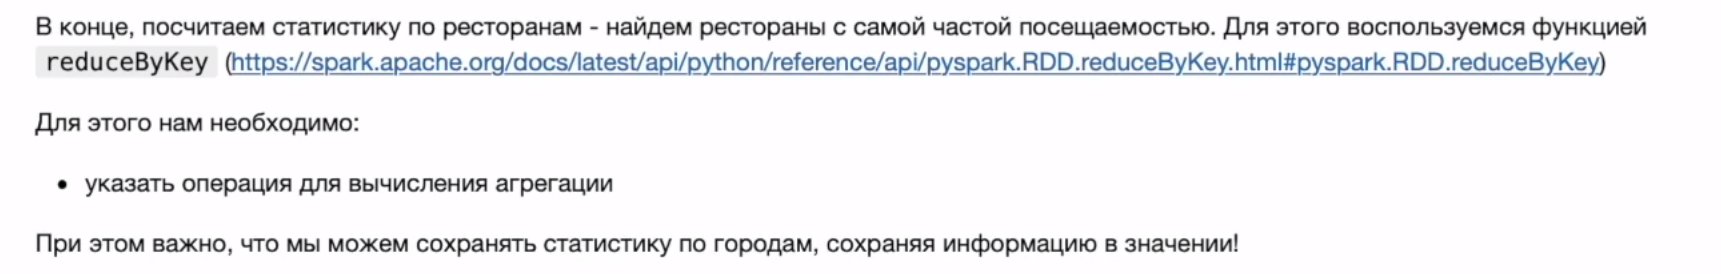

In [19]:
def reduceValues(value1, value2):
    count_1 = value1.get('count', 1)
    count_2 = value2.get('count', 1)
    
    return {
        'city': value1['city'],
        'longitude': value1['longitude'],
        'latitude': value1['latitude'],
        'stars': value1['stars'] + value2['stars'],
        'count': count_1 + count_2
    }

In [20]:
business_stats = joined_rdd_projection.reduceByKey(reduceValues)

In [21]:
business_stats.take(5)

[('KC4Eo1S3AMA2qk8ULiLEkg',
  {'city': 'Nashville',
   'longitude': -86.7785167696,
   'latitude': 36.1591434847,
   'stars': 896.0,
   'count': 233}),
 ('zedtiorJSVxjpqMKdyp9TA',
  {'city': 'Reno',
   'longitude': -119.7651107,
   'latitude': 39.3947087,
   'stars': 338.0,
   'count': 124}),
 ('O9Zg386O4EL-ihUrx8BcpQ',
  {'city': 'Reno',
   'longitude': -119.7671633,
   'latitude': 39.4732946,
   'stars': 35.0,
   'count': 7}),
 ('LK_ezKtxOkrGwlqPNx_1aA',
  {'city': 'Exton',
   'longitude': -75.6319749355,
   'latitude': 40.029499855,
   'stars': 44.0,
   'count': 12}),
 ('Y-2Vjxwv5TbV_Wfnxei6Vg',
  {'city': 'Sherwood Park',
   'longitude': -113.3190176,
   'latitude': 53.5639992,
   'stars': 35.0,
   'count': 8})]

In [29]:
def get_average(business):
    return (
        business[0],
        {
            'city': business[1]['city'],
            'longitude': business[1]['longitude'],
            'latitude': business[1]['latitude'],
            'avg': business[1]['stars'] / business[1]['count'],
            'count': business[1]['count']
        }
    )

In [30]:
business_stats_avg = business_stats.map(get_average)

In [31]:
business_stats_avg.take(5)

[('KC4Eo1S3AMA2qk8ULiLEkg',
  {'city': 'Nashville',
   'longitude': -86.7785167696,
   'latitude': 36.1591434847,
   'avg': 3.8454935622317596,
   'count': 233}),
 ('zedtiorJSVxjpqMKdyp9TA',
  {'city': 'Reno',
   'longitude': -119.7651107,
   'latitude': 39.3947087,
   'avg': 2.725806451612903,
   'count': 124}),
 ('O9Zg386O4EL-ihUrx8BcpQ',
  {'city': 'Reno',
   'longitude': -119.7671633,
   'latitude': 39.4732946,
   'avg': 5.0,
   'count': 7}),
 ('LK_ezKtxOkrGwlqPNx_1aA',
  {'city': 'Exton',
   'longitude': -75.6319749355,
   'latitude': 40.029499855,
   'avg': 3.6666666666666665,
   'count': 12}),
 ('Y-2Vjxwv5TbV_Wfnxei6Vg',
  {'city': 'Sherwood Park',
   'longitude': -113.3190176,
   'latitude': 53.5639992,
   'avg': 4.375,
   'count': 8})]

In [32]:
business_stats_avg_sorted = business_stats_avg.sortBy(lambda x: (-x[1]['avg'], -x[1]['count']))

In [33]:
business_stats_avg_sorted.take(5)

[('1RqfozJoosHAsKZhc5PY7w',
  {'city': 'Nashville',
   'longitude': -86.7814135551,
   'latitude': 36.1629634175,
   'avg': 5.0,
   'count': 114}),
 ('-siOxQQcGKtb-04dX0Cxnw',
  {'city': 'Santa Barbara',
   'longitude': -119.7107494,
   'latitude': 34.420334,
   'avg': 5.0,
   'count': 104}),
 ('4-P4Bzqd01YvKX9tp7IGfQ',
  {'city': 'New Orleans',
   'longitude': -90.064372191,
   'latitude': 29.9650686696,
   'avg': 5.0,
   'count': 90}),
 ('dhLARBhUnJloLa8xZ1Stpw',
  {'city': 'Cherry Hill',
   'longitude': -74.9816935298,
   'latitude': 39.9087959983,
   'avg': 5.0,
   'count': 78}),
 ('LTqm4uY4GIYHfzuh5pVZNQ',
  {'city': 'Reno',
   'longitude': -119.8061095381,
   'latitude': 39.5035164859,
   'avg': 5.0,
   'count': 77})]

Сохраним данные в hdfs. Для этого сохраним информацию в json формате

In [38]:
def to_json(business):
    return {
        'business_id': business[0],
        'city': business[1]['city'],
        'longitude': business[1]['longitude'],
        'latitude': business[1]['latitude'],
        'avg': business[1]['avg'],
        'count': business[1]['count']
    }

In [39]:
business_stats_avg_sorted.map(
    to_json
).take(10)

[{'business_id': '1RqfozJoosHAsKZhc5PY7w',
  'city': 'Nashville',
  'longitude': -86.7814135551,
  'latitude': 36.1629634175,
  'avg': 5.0,
  'count': 114},
 {'business_id': '-siOxQQcGKtb-04dX0Cxnw',
  'city': 'Santa Barbara',
  'longitude': -119.7107494,
  'latitude': 34.420334,
  'avg': 5.0,
  'count': 104},
 {'business_id': '4-P4Bzqd01YvKX9tp7IGfQ',
  'city': 'New Orleans',
  'longitude': -90.064372191,
  'latitude': 29.9650686696,
  'avg': 5.0,
  'count': 90},
 {'business_id': 'dhLARBhUnJloLa8xZ1Stpw',
  'city': 'Cherry Hill',
  'longitude': -74.9816935298,
  'latitude': 39.9087959983,
  'avg': 5.0,
  'count': 78},
 {'business_id': 'LTqm4uY4GIYHfzuh5pVZNQ',
  'city': 'Reno',
  'longitude': -119.8061095381,
  'latitude': 39.5035164859,
  'avg': 5.0,
  'count': 77},
 {'business_id': 'x-SCuOwghy4GlZdVOKjt4g',
  'city': 'Santa Barbara',
  'longitude': -119.6981901,
  'latitude': 34.4208305,
  'avg': 5.0,
  'count': 74},
 {'business_id': '2FQoAp9w0G_NhuZMqo9bfA',
  'city': 'Santa Barbar

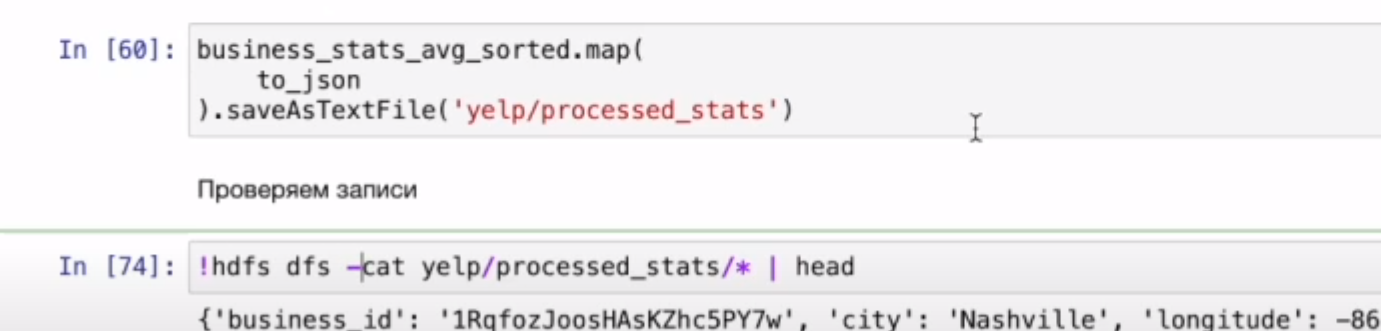

In [ ]:
# сохраняем данные 
business_stats_avg_sorted.map(
    to_json
).saveAsTextFile('yelp/processed_stats')

In [ ]:
# второй вариант с задание кол-ва партиций
business_stats_avg_sorted.map(
    to_json
).repertition(2).saveAsTextFile('yelp/processed_stats')

In [ ]:
!hdfs dfs -cat yelp/processed_stats/* | head